In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
import gc
from datetime import datetime
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoost, Pool

In [2]:
train_base = pd.read_csv("./比赛数据/train_X.csv")
train_y = pd.read_csv("./比赛数据/train_y.csv")

test_a_base = pd.read_csv("./比赛数据/test_X.csv")

In [3]:
train_base = train_base.merge(train_y, on = 'ID', how = 'left')
data = pd.concat([train_base,test_a_base],axis = 0).reset_index(drop=True)
# 删去无用信息行
delete_idx = np.where(data["净利润"].isnull())[0]
data.drop(delete_idx, inplace=True, axis = 0)
data = data.reset_index(drop=True)

In [4]:
data

,ID,流动比率,资产负债率,销售毛利率,净资产收益率,投入资本回报率,总资产报酬率,应收款周转率,营业收入,所得税,销售额,经营活动产生的现金流量净额,净利润,资产总计,负债合计,所有者权益合计,label
0,0,0.5577,55.3147,25.2605,1.9564,2.1862,2.4826,3.3153,7.845137e+08,9951614.16,6.006981e+08,6.157414e+07,2.126697e+07,3.085870e+09,1.706939e+09,1.378931e+09,0.0
1,1,1.9720,46.4108,28.6456,16.8202,15.0350,11.9568,3.4728,1.834229e+08,3605181.39,2.953570e+08,1.651039e+07,2.507505e+07,2.767440e+08,1.284392e+08,1.483049e+08,0.0
2,2,1.9002,53.9537,34.4586,NaN,-13.5247,-11.1792,10.4994,3.068515e+08,NaN,3.211981e+08,2.110488e+07,-4.468525e+07,3.997174e+08,2.156623e+08,1.840551e+08,0.0
3,3,4.8713,17.4401,46.8673,21.6078,19.9251,18.2743,10.9375,3.053438e+08,6921549.79,2.926854e+08,-6.076354e+07,4.631724e+07,3.629337e+08,6.329601e+07,2.996377e+08,0.0
4,4,1.2952,67.8441,13.4894,10.8501,9.7614,5.8651,2.1053,4.625373e+09,30281297.37,3.168372e+09,-2.790123e+08,1.708486e+08,5.307375e+09,3.600744e+09,1.706632e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10311,3371,6.2641,12.7225,36.8816,23.2800,23.2182,23.7397,4.7184,4.185612e+08,12055109.84,3.085054e+08,4.290525e+07,7.404769e+07,3.956815e+08,5.034055e+07,3.453409e+08,NaN
10312,3372,1.6064,33.9201,17.5533,-43.6215,-39.5711,-31.8436,0.5785,3.031451e+08,-30733579.69,4.977715e+08,1.362391e+07,-6.979324e+08,1.853798e+09,6.288107e+08,1.224988e+09,NaN
10313,3373,2.6823,27.9781,32.1184,12.9491,11.4496,12.0724,2.5286,2.569393e+09,82804408.83,2.361340e+09,2.321388e+08,3.867297e+08,4.416607e+09,1.235683e+09,3.180924e+09,NaN
10314,3374,1.6402,56.4199,24.4194,8.8831,7.6144,4.6724,2.2646,4.628142e+08,6768236.62,6.403150e+08,1.914272e+08,5.250324e+07,1.404934e+09,7.926626e+08,6.122717e+08,NaN


In [5]:
data['label'].value_counts(normalize=True)

0.0    0.996254
1.0    0.003746
Name: label, dtype: float64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10316 entries, 0 to 10315
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             10316 non-null  int64  
 1   流动比率           10294 non-null  float64
 2   资产负债率          10316 non-null  float64
 3   销售毛利率          10265 non-null  float64
 4   净资产收益率         9986 non-null   float64
 5   投入资本回报率        10258 non-null  float64
 6   总资产报酬率         10268 non-null  float64
 7   应收款周转率         10217 non-null  float64
 8   营业收入           10305 non-null  float64
 9   所得税            10220 non-null  float64
 10  销售额            10267 non-null  float64
 11  经营活动产生的现金流量净额  10316 non-null  float64
 12  净利润            10316 non-null  float64
 13  资产总计           10316 non-null  float64
 14  负债合计           10316 non-null  float64
 15  所有者权益合计        10316 non-null  float64
 16  label          6940 non-null   float64
dtypes: float64(16), int64(1)
memory usage: 1.3 MB


In [7]:
maps = {'流动比率':'col_1'
        ,'资产负债率':'col_2'
        , '销售毛利率':'col_3'
        ,'净资产收益率':'col_4'
        , '投入资本回报率':'col_5'
        , '总资产报酬率':'col_6'
        , '应收款周转率':'col_7'
        , '营业收入':'col_8'
        , '所得税':'col_9'
        , '销售额':'col_10'
        , '经营活动产生的现金流量净额':'col_11'
        , '净利润':'col_12'
        , '资产总计':'col_13'
        , '负债合计':'col_14'
        , '所有者权益合计':'col_15'}
data = data.rename(columns = maps)

In [8]:
data

,ID,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,label
0,0,0.5577,55.3147,25.2605,1.9564,2.1862,2.4826,3.3153,7.845137e+08,9951614.16,6.006981e+08,6.157414e+07,2.126697e+07,3.085870e+09,1.706939e+09,1.378931e+09,0.0
1,1,1.9720,46.4108,28.6456,16.8202,15.0350,11.9568,3.4728,1.834229e+08,3605181.39,2.953570e+08,1.651039e+07,2.507505e+07,2.767440e+08,1.284392e+08,1.483049e+08,0.0
2,2,1.9002,53.9537,34.4586,NaN,-13.5247,-11.1792,10.4994,3.068515e+08,NaN,3.211981e+08,2.110488e+07,-4.468525e+07,3.997174e+08,2.156623e+08,1.840551e+08,0.0
3,3,4.8713,17.4401,46.8673,21.6078,19.9251,18.2743,10.9375,3.053438e+08,6921549.79,2.926854e+08,-6.076354e+07,4.631724e+07,3.629337e+08,6.329601e+07,2.996377e+08,0.0
4,4,1.2952,67.8441,13.4894,10.8501,9.7614,5.8651,2.1053,4.625373e+09,30281297.37,3.168372e+09,-2.790123e+08,1.708486e+08,5.307375e+09,3.600744e+09,1.706632e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10311,3371,6.2641,12.7225,36.8816,23.2800,23.2182,23.7397,4.7184,4.185612e+08,12055109.84,3.085054e+08,4.290525e+07,7.404769e+07,3.956815e+08,5.034055e+07,3.453409e+08,NaN
10312,3372,1.6064,33.9201,17.5533,-43.6215,-39.5711,-31.8436,0.5785,3.031451e+08,-30733579.69,4.977715e+08,1.362391e+07,-6.979324e+08,1.853798e+09,6.288107e+08,1.224988e+09,NaN
10313,3373,2.6823,27.9781,32.1184,12.9491,11.4496,12.0724,2.5286,2.569393e+09,82804408.83,2.361340e+09,2.321388e+08,3.867297e+08,4.416607e+09,1.235683e+09,3.180924e+09,NaN
10314,3374,1.6402,56.4199,24.4194,8.8831,7.6144,4.6724,2.2646,4.628142e+08,6768236.62,6.403150e+08,1.914272e+08,5.250324e+07,1.404934e+09,7.926626e+08,6.122717e+08,NaN


# 构建特征

In [9]:
# 构建特征 所得税 - 净利润 * 1/3
data["col_16"] = data["col_9"] - data["col_12"] * 1/3

In [10]:
# 构建特征 所得税 - 净利润 * 1/3
data["col_17"] = data["col_9"]
for i in range(len(data["col_17"])):
    if data.loc[i, "col_12"] >= 0:
        data.loc[i, "col_17"] = data.loc[i, "col_9"] - data.loc[i, "col_12"] * 1/3

In [11]:
data["col_8_col_12"] = data["col_8"] / data["col_12"]

In [84]:
drop_cols = ['ID','label', "col_1", "col_3", "col_4", "col_7", "col_9", "col_15", "col_16"]
cate_cols = [] # 类别变量

In [85]:
dense_cols = [col for col in data.columns if col not in drop_cols + cate_cols]
dense_cols

['col_2',
 'col_5',
 'col_6',
 'col_8',
 'col_10',
 'col_11',
 'col_12',
 'col_13',
 'col_14',
 'col_17',
 'col_8_col_12']

In [86]:
test_df = data[data["label"].isnull() == True].copy().reset_index(drop=True)
train_df = data[~data["label"].isnull() == True].copy().reset_index(drop=True)

In [87]:
unique_1_cols = []
for col in data.columns:
    if data[col].nunique() < 2:
        unique_1_cols.append(col)
print(unique_1_cols)

[]


In [88]:
feature_name = [i for i in train_df.columns if i not in drop_cols+unique_1_cols]
X_train = train_df[feature_name].reset_index(drop=True)
X_test = test_df[feature_name].reset_index(drop=True)
y = train_df['label'].reset_index(drop=True)
print(feature_name)
print(len(feature_name))

['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_17', 'col_8_col_12']
11


In [89]:
X_train

,col_2,col_5,col_6,col_8,col_10,col_11,col_12,col_13,col_14,col_17,col_8_col_12
0,55.3147,2.1862,2.4826,7.845137e+08,6.006981e+08,6.157414e+07,2.126697e+07,3.085870e+09,1.706939e+09,2.862624e+06,36.888828
1,46.4108,15.0350,11.9568,1.834229e+08,2.953570e+08,1.651039e+07,2.507505e+07,2.767440e+08,1.284392e+08,-4.753167e+06,7.314958
2,53.9537,-13.5247,-11.1792,3.068515e+08,3.211981e+08,2.110488e+07,-4.468525e+07,3.997174e+08,2.156623e+08,NaN,-6.866953
3,17.4401,19.9251,18.2743,3.053438e+08,2.926854e+08,-6.076354e+07,4.631724e+07,3.629337e+08,6.329601e+07,-8.517530e+06,6.592444
4,67.8441,9.7614,5.8651,4.625373e+09,3.168372e+09,-2.790123e+08,1.708486e+08,5.307375e+09,3.600744e+09,-2.666824e+07,27.072929
...,...,...,...,...,...,...,...,...,...,...,...
6935,13.8128,9.9544,10.6771,3.440158e+08,2.510770e+08,-1.266145e+06,6.114183e+07,7.357635e+08,1.016296e+08,-7.148791e+06,5.626521
6936,33.5725,11.5307,10.3301,1.815627e+09,1.531822e+09,1.769861e+08,2.865325e+08,3.699111e+09,1.241883e+09,-5.471366e+07,6.336547
6937,11.6883,6.0328,6.4704,6.391005e+08,5.054549e+08,-4.904489e+07,1.813611e+08,3.209914e+09,3.751844e+08,-4.861045e+07,3.523912
6938,48.9150,11.0918,7.4979,1.583693e+09,1.125913e+09,2.149797e+08,1.327308e+08,2.399152e+09,1.173546e+09,-2.044853e+07,11.931619


In [90]:
seeds = [0, 4, 2, 209, 4096, 2048, 1024, 2015, 1015, 820]
num_model_seed = 1
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
parameters = {
    "learning_rate": 0.05,
    "objective": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 2022,
    "subsample": 0.8,
    "num_boost_round": 10000
}
fold = 5
train_shape = X_train.shape[0]
test_shape = X_test.shape[0]
X_test = Pool(X_test)
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(train_shape)
    prediction_cat = np.zeros(test_shape)
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = Pool(train_x, train_y)
        dval = Pool(test_x, test_y)
        cb_model = CatBoost(parameters)
        cb_model.fit(
            dtrain,
            eval_set = dval,
            early_stopping_rounds=200,
            verbose_eval=100,
        )
        test_x = Pool(test_x)
        
        oof_cat[test_index] += cb_model.predict(test_x, prediction_type = "Probability", ntree_start = 0, ntree_end = cb_model.best_iteration_)[:, 1]
        prediction_cat += cb_model.predict(X_test, prediction_type = "Probability", ntree_start = 0, ntree_end = cb_model.best_iteration_)[:, 1] / fold
        feat_imp_df['imp'] += list(cb_model.feature_importances_)

        del train_x
        del test_x
        del train_y
        del test_y
        del cb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
gc.collect()

0 --------------------------------------------------------------------------------------------
0:	test: 0.9212581	best: 0.9212581 (0)	total: 3.74ms	remaining: 37.4s
100:	test: 0.9276934	best: 0.9823572 (3)	total: 352ms	remaining: 34.5s
200:	test: 0.9068691	best: 0.9823572 (3)	total: 706ms	remaining: 34.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9823571945
bestIteration = 3

Shrink model to first 4 iterations.
0:	test: 0.9584237	best: 0.9584237 (0)	total: 3.72ms	remaining: 37.2s
100:	test: 0.9986985	best: 0.9998554 (21)	total: 416ms	remaining: 40.7s
200:	test: 0.9991323	best: 0.9998554 (21)	total: 789ms	remaining: 38.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9998553868
bestIteration = 21

Shrink model to first 22 iterations.
0:	test: 0.8259581	best: 0.8259581 (0)	total: 18.6ms	remaining: 3m 5s
100:	test: 0.9596529	best: 0.9738250 (32)	total: 380ms	remaining: 37.2s
200:	test: 0.9519884	best: 0.9738250 (32)	total: 739ms	remaining:

9058

In [91]:
train_auc = roc_auc_score(y,oof)
print("AUC:",train_auc)

AUC: 0.7643549320219845


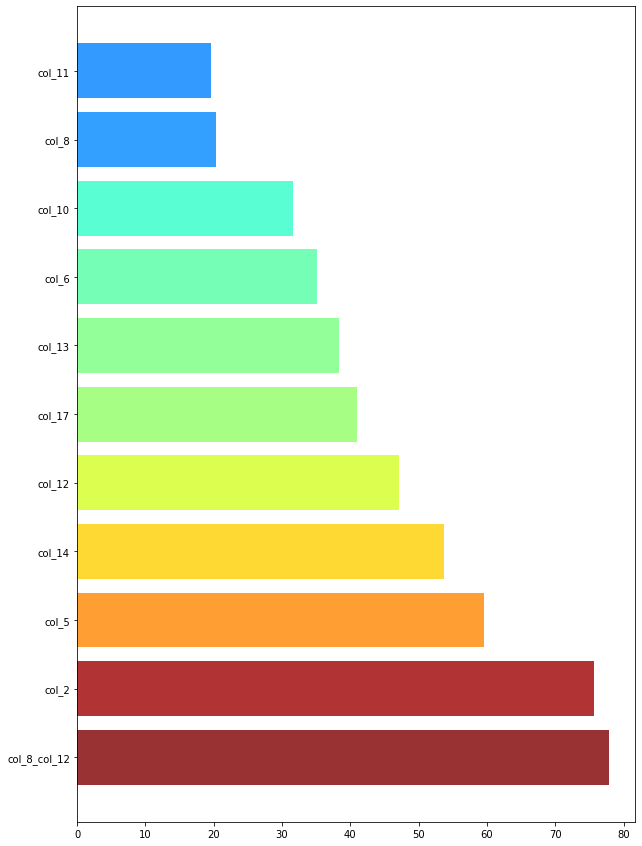

In [92]:
#查看模型的特征重要性
import matplotlib.pyplot as plt 
from matplotlib import cm

score = feat_imp_df.sort_values(['imp'], ascending=False)
temp = pd.DataFrame()
temp = score[:60]
color = cm.jet(temp['imp']/temp['imp'].max())
plt.figure(figsize=(10, 15))
plt.barh(temp['feats'],temp['imp'],height =0.8,color=color,alpha=0.8)
plt.show()

# 测试集

In [93]:
test2 = test_df.copy()
test2['y_score'] = prediction

In [94]:
test2[['ID','y_score']].to_csv("./结果提交/4.7/submit_{}.csv".format(round(train_auc,5)),index=False)

In [ ]:
lr = 0.01
['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16'] -> 0.9258
['col_1', 'col_2', 'col_3', 'col_5', 'col_6', 'col_7', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16'] -> 0.9370
['col_1', 'col_2', 'col_3', 'col_5', 'col_6', 'col_7', 'col_8', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16'] -> 0.9258

In [ ]:
lr = 0.05
['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16'] -> 0.9396
['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14'] -> 0.9253
['col_1', 'col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16'] -> 0.9530
['col_1', 'col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_12', 'col_13', 'col_14', 'col_16'] -> 0.9264
['col_1', 'col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16', 'col_12_col_8'] -> 0.9355
['col_1', 'col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16', 'col_8_col_12'] -> 0.9370
['col_1', 'col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_8_col_12'] -> 0.9463
['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_17'] -> 0.9385
['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_17', 'col_8_col_12'] -> 0.9510
['col_1', 'col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_17', 'col_8_col_12'] -> 0.9337
['col_2', 'col_5', 'col_6', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_17', 'col_8_col_12'] -> 0.9506


In [ ]:
lr = 0.1
['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16'] -> 0.9347

In [ ]:
seed = 0 , lr = 0.05
['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_17', 'col_8_col_12'] -> 0.9516